# 1. Import and Install Dependencies

In [ ]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# 2. Keypoints using MP Holistic

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [5]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

# 3. Extract Keypoint Values

In [6]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

# 4. Setup Folders for Collection

In [7]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('real_time_data') 

# Actions that we try to detect
actions = np.array(['hello', 'thanks', 'iloveyou'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# 5. Collect Keypoint Values for Training and Testing

In [8]:
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
#                 print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
cap.release()
cv2.destroyAllWindows()

# 6. Preprocess Data and Create Labels and Features

In [9]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [10]:
label_map = {label:num for num, label in enumerate(actions)}

In [11]:
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [12]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [13]:
np.array(sequences).shape

(90, 30, 1662)

In [14]:
np.array(labels).shape

(90,)

In [15]:
X = np.array(sequences)

In [16]:
X.shape

(90, 30, 1662)

In [17]:
y = to_categorical(labels).astype(int)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [19]:
y_test.shape

(5, 3)

# 7. Build and Train LSTM Neural Network

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow import lite

In [21]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [22]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [23]:
res = [.7, 0.2, 0.1]

In [24]:
actions[np.argmax(res)]

'hello'

In [25]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [26]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000
3/3 [==============================] - 4s 165ms/step - loss: 1.3238 - categorical_accuracy: 0.3059
Epoch 2/2000
3/3 [==============================] - 0s 141ms/step - loss: 1.3563 - categorical_accuracy: 0.2588
Epoch 3/2000
3/3 [==============================] - 0s 134ms/step - loss: 1.1794 - categorical_accuracy: 0.3765
Epoch 4/2000
3/3 [==============================] - 0s 154ms/step - loss: 1.2287 - categorical_accuracy: 0.2706
Epoch 5/2000
3/3 [==============================] - 0s 141ms/step - loss: 1.1450 - categorical_accuracy: 0.4118
Epoch 6/2000
3/3 [==============================] - 0s 145ms/step - loss: 1.0754 - categorical_accuracy: 0.4000
Epoch 7/2000
3/3 [==============================] - 0s 154ms/step - loss: 1.0370 - categorical_accuracy: 0.4471
Epoch 8/2000
3/3 [==============================] - 0s 156ms/step - loss: 0.8871 - categorical_accuracy: 0.5059
Epoch 9/2000
3/3 [==============================] - 0s 143ms/step - loss: 0.9007 - categorical_accuracy:

3/3 [==============================] - 0s 153ms/step - loss: 0.3494 - categorical_accuracy: 0.8706
Epoch 74/2000
3/3 [==============================] - 0s 128ms/step - loss: 0.3914 - categorical_accuracy: 0.7882
Epoch 75/2000
3/3 [==============================] - 0s 147ms/step - loss: 0.4209 - categorical_accuracy: 0.7882
Epoch 76/2000
3/3 [==============================] - 0s 162ms/step - loss: 0.5130 - categorical_accuracy: 0.6588
Epoch 77/2000
3/3 [==============================] - 0s 164ms/step - loss: 0.4180 - categorical_accuracy: 0.7882
Epoch 78/2000
3/3 [==============================] - 0s 154ms/step - loss: 0.3849 - categorical_accuracy: 0.8118
Epoch 79/2000
3/3 [==============================] - 0s 160ms/step - loss: 0.3709 - categorical_accuracy: 0.8235
Epoch 80/2000
3/3 [==============================] - 0s 135ms/step - loss: 0.3076 - categorical_accuracy: 0.8941
Epoch 81/2000
3/3 [==============================] - 0s 144ms/step - loss: 0.3430 - categorical_accuracy: 0.84

3/3 [==============================] - 0s 150ms/step - loss: 0.1826 - categorical_accuracy: 0.9412
Epoch 146/2000
3/3 [==============================] - 0s 150ms/step - loss: 0.1511 - categorical_accuracy: 0.9412
Epoch 147/2000
3/3 [==============================] - 0s 163ms/step - loss: 0.1075 - categorical_accuracy: 0.9765
Epoch 148/2000
3/3 [==============================] - 0s 147ms/step - loss: 0.1254 - categorical_accuracy: 0.9647
Epoch 149/2000
3/3 [==============================] - 0s 127ms/step - loss: 0.1214 - categorical_accuracy: 0.9294
Epoch 150/2000
3/3 [==============================] - 0s 142ms/step - loss: 0.1496 - categorical_accuracy: 0.9412
Epoch 151/2000
3/3 [==============================] - 0s 122ms/step - loss: 0.1494 - categorical_accuracy: 0.9412
Epoch 152/2000
3/3 [==============================] - 0s 129ms/step - loss: 0.0966 - categorical_accuracy: 0.9765
Epoch 153/2000
3/3 [==============================] - 0s 134ms/step - loss: 0.2008 - categorical_accura

3/3 [==============================] - 0s 155ms/step - loss: 2.4077e-04 - categorical_accuracy: 1.0000
Epoch 217/2000
3/3 [==============================] - 0s 155ms/step - loss: 2.2570e-04 - categorical_accuracy: 1.0000
Epoch 218/2000
3/3 [==============================] - 0s 152ms/step - loss: 2.0337e-04 - categorical_accuracy: 1.0000
Epoch 219/2000
3/3 [==============================] - 0s 163ms/step - loss: 1.8440e-04 - categorical_accuracy: 1.0000
Epoch 220/2000
3/3 [==============================] - 0s 166ms/step - loss: 1.7315e-04 - categorical_accuracy: 1.0000
Epoch 221/2000
3/3 [==============================] - 0s 141ms/step - loss: 1.5928e-04 - categorical_accuracy: 1.0000
Epoch 222/2000
3/3 [==============================] - 0s 139ms/step - loss: 1.4340e-04 - categorical_accuracy: 1.0000
Epoch 223/2000
3/3 [==============================] - 0s 151ms/step - loss: 1.3329e-04 - categorical_accuracy: 1.0000
Epoch 224/2000
3/3 [==============================] - 0s 121ms/step - l

KeyboardInterrupt: 

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 596,675
Trainable params: 596,675
Non-trai

# 8. Make Predictions

In [28]:
res = model.predict(X_test)

1/1 [==============================] - 0s 305ms/step


In [34]:
actions[np.argmax(res[2])]

'iloveyou'

In [35]:
actions[np.argmax(y_test[2])]

'iloveyou'

# 9. Save Weights

In [36]:
import tensorflow as tf

In [39]:
tf.saved_model.save(model,'')

INFO:tensorflow:Assets written to: assets


In [46]:
converter=tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_new_converter=True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
tf.lite.OpsSet.SELECT_TF_OPS]

In [47]:
tfmodel = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\hp\AppData\Local\Temp\tmpi3xkgnex\assets


INFO:tensorflow:Assets written to: C:\Users\hp\AppData\Local\Temp\tmpi3xkgnex\assets


In [50]:
with open('model.tflite','wb') as f:
    f.write(tfmodel)

In [51]:
#------------------------------------

In [ ]:
model = tf.keras.models.load_model('action.h5')

In [40]:
model.save('action.h5')

In [13]:
model.load_weights('action.h5')

# 10. Evaluation using Confusion Matrix and Accuracy

In [15]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [28]:
yhat = model.predict(X_test)

1/1 [==============================] - 3s 3s/step


In [29]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [30]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[3, 0],
        [1, 1]],

       [[1, 1],
        [0, 3]]], dtype=int64)

In [ ]:
accuracy_score(ytrue, yhat)

# 11. Test in Real Time

In [34]:
colors = [(245,117,16), (117,245,16), (16,117,245),(0,0,210)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

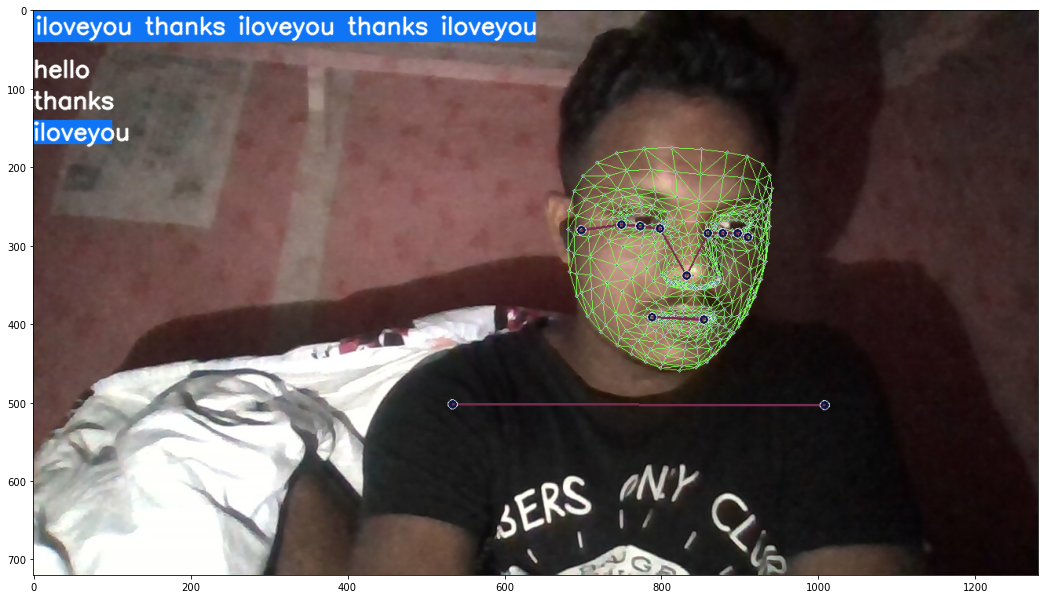

In [35]:
plt.figure(figsize=(18,18))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(prob_viz(res, actions, image, colors))

In [ ]:
sequence.reverse()

In [ ]:
len(sequence)

In [ ]:
sequence.append('def')

In [ ]:
sequence.reverse()

In [ ]:
sequence[-30:]

In [33]:
# 1. New detection variables
sequence = []
sentence = []
threshold = 0.8

cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 2000);
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 1000);
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
#         sequence.insert(0,keypoints)
#         sequence = sequence[:30]
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            
            
        #3. Viz logic
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

1/1 [==============================] - 0s 70ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 65ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 77ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 76ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 78ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 65ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 79ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 63ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 91ms/step
iloveyou
<clas

1/1 [==============================] - 0s 66ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 76ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 62ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 77ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 72ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 72ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 64ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 71ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 63ms/step
iloveyou

1/1 [==============================] - 0s 63ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 72ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 65ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 64ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 65ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 74ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 85ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 69ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 63ms/step
ilov

In [ ]:
cap.release()
cv2.destroyAllWindows()

In [ ]:
res[np.argmax(res)] > threshold

In [ ]:
(num_sequences,30,1662)

In [ ]:
model.predict(np.expand_dims(X_test[0], axis=0))

# 12. Conversion to tflite model

In [41]:
from tensorflow import lite

In [39]:
print(help(lite.TFLiteConverter))

Help on class TFLiteConverterV2 in module tensorflow.lite.python.lite:

class TFLiteConverterV2(TFLiteFrozenGraphConverterV2)
 |  TFLiteConverterV2(funcs, trackable_obj=None)
 |  
 |  Converts a TensorFlow model into TensorFlow Lite model.
 |  
 |  Attributes:
 |    optimizations: Experimental flag, subject to change. Set of optimizations to
 |      apply. e.g {tf.lite.Optimize.DEFAULT}. (default None, must be None or a
 |      set of values of type `tf.lite.Optimize`)
 |    representative_dataset: A generator function used for integer quantization
 |      where each generated sample has the same order, type and shape as the
 |      inputs to the model. Usually, this is a small subset of a few hundred
 |      samples randomly chosen, in no particular order, from the training or
 |      evaluation dataset. This is an optional attribute, but required for full
 |      integer quantization, i.e, if `tf.int8` is the only supported type in
 |      `target_spec.supported_types`. Refer to `tf.

In [42]:
converter=lite.TFLiteConverter.from_saved_model('action.h5')

OSError: SavedModel file does not exist at: action.h5\{saved_model.pbtxt|saved_model.pb}